# Product Range Analysis

#### Scope of this project:
The overall goal is to identify top selling products and key customers and at the same time to drastically reduce total product offer in order to increase efficiency and profitability.
Moreover, less focus is put on cancellations, returns, bank charges or postage as we try to focus more on predictions about optimal description length and seasonality.

In [1]:
# Data Structures
import numpy  as np
import pandas as pd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sb
from sklearn.metrics                  import silhouette_samples, silhouette_score

from nltk.corpus import stopwords
from datetime import timedelta
import squarify

In [2]:
# read data
df_pre = pd.read_csv('ecommerce_data.csv', sep='\t')
#check data
df_pre.head()

,InvoiceNo;StockCode;Description;Quantity;InvoiceDate;UnitPrice;CustomerID
0,536365;85123A;WHITE HANGING HEART T-LIGHT HOLD...
1,536365;71053;WHITE METAL LANTERN;6;11/29/2018 ...
2,536365;84406B;CREAM CUPID HEARTS COAT HANGER;8...
3,536365;84029G;KNITTED UNION FLAG HOT WATER BOT...
4,536365;84029E;RED WOOLLY HOTTIE WHITE HEART.;6...


## 1. Data Exploration and Preprocssing

In [3]:
#Split data to get columns that are easy to interpret
df_imd = df_pre['InvoiceNo;StockCode;Description;Quantity;InvoiceDate;UnitPrice;CustomerID'].str.split(pat=';',expand=True)
# rename columns
df_imd.columns = ['InvoiceNo','StockCode','Description', 'Quantity', 'InvoiceDate','UnitPrice','CustomerID']

In [4]:
# check columns
df_imd.head(112)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850
...,...,...,...,...,...,...,...
107,536381,84854,GIRLY PINK TOOL SET,5,11/29/2018 09:41,4.95,15311
108,536381,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,11/29/2018 09:41,1.95,15311
109,536381,82567,"AIRLINE LOUNGE,METAL SIGN",2,11/29/2018 09:41,2.1,15311
110,536381,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,6,11/29/2018 09:41,1.25,15311


In [5]:
# copy data
df = df_imd.copy()

In [6]:
# inspecting data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    541909 non-null  object
 1   StockCode    541909 non-null  object
 2   Description  541909 non-null  object
 3   Quantity     541909 non-null  object
 4   InvoiceDate  541909 non-null  object
 5   UnitPrice    541909 non-null  object
 6   CustomerID   541909 non-null  object
dtypes: object(7)
memory usage: 28.9+ MB


In [7]:
#change data types
df['Quantity'] = df['Quantity'].astype('int')
df['UnitPrice'] = df['UnitPrice'].astype('float')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
# checking for null values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

The code does not display null values, but it is easy to see that there are some in the Customer ID and Description Column by just doing visual assessment.

In [9]:
# identifying missing values as null values
for column in df.columns:
    df[column] = df[column].replace('',np.nan)

In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

In [11]:
# inspecting the small amount of missing description data
display(df[df['Description'].isna()].head())
print('- The Unit Price mean of products with missing Description is {}.'.format(df[df['Description'].isna()]['UnitPrice'].mean()))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN
1971,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN
1972,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,NaN


- The Unit Price mean of products with missing Description is 0.0.


About one third of total CustomerIDs is missing, so it would be difficult if we would delete all of them. Besides, there are 1454 missing values for Description. I will delete them because they only account for a very small percentage of the data, sometimes have negative quantities (which is confusing at first glance) and all have a unit price of 0.0.

In [12]:
# delete rows with missing Description data
df.dropna(subset=['Description'], how='any', inplace=True)

In [13]:
# checking for duplicate values
df[df.duplicated() == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2018-11-29 11:45:00,1.25,17908
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2018-11-29 11:45:00,2.10,17908
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2018-11-29 11:45:00,2.95,17908
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2018-11-29 11:45:00,4.95,17908
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2018-11-29 11:49:00,2.95,17920
...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2019-12-07 11:34:00,0.39,14446
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2019-12-07 11:34:00,2.49,14446
541692,581538,22992,REVOLVER WOODEN RULER,1,2019-12-07 11:34:00,1.95,14446
541699,581538,22694,WICKER STAR,1,2019-12-07 11:34:00,2.10,14446


In [14]:
# deleting the 5269 duplicate rows (I have also rechecked if the duplicates are due to the fact that I had removed the time from
# the date column in a previous cell but this is not the case.)
df.drop_duplicates(keep='first', inplace=True)

In [15]:
# checking quantity column for anomalies and outliers
df['Quantity'].describe()

count    535187.000000
mean          9.671593
std         219.059056
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [16]:
# we can see that there are 9725 rows with negative quantities, most of them containing a C in their Invoice, which probably
# refers to something like cancellation or products that were thrown away. For my particular analysis, negative values are
# irrelevant and can be removed completely as they don't add any value to my hypotheses and only make up 1.8% of total data.
df= df[df['Quantity'] >= 0 ]

In [17]:
# checking UnitPrice column for anomalies and outliers
df['UnitPrice'].describe()

count    525462.000000
mean          3.876109
std          42.040021
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [18]:
#There are two negative UnitPrices (which are irrelevant) and 580 UnitPrices of 0. These could have been potentially interesting
# but because of the missing pattern and the very, very low percentage of data, these will be removed as well.
df = df[df['UnitPrice'] > 0]

In [19]:
# inspecting the number of rows which contain postage references
df[df['Description'].str.contains('POSTAGE')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
45,536370,POST,POSTAGE,3,2018-11-29 08:45:00,18.00,12583
386,536403,POST,POSTAGE,1,2018-11-29 11:27:00,15.00,12791
1123,536527,POST,POSTAGE,1,2018-11-29 13:04:00,18.00,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2018-11-29 14:32:00,569.77,NaN
3041,536592,DOT,DOTCOM POSTAGE,1,2018-11-29 17:06:00,607.49,NaN
...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,2019-12-07 10:13:00,18.00,12518
541540,581498,DOT,DOTCOM POSTAGE,1,2019-12-07 10:26:00,1714.17,NaN
541730,581570,POST,POSTAGE,1,2019-12-07 11:59:00,18.00,12662
541767,581574,POST,POSTAGE,2,2019-12-07 12:09:00,18.00,12526


In [20]:
# dropping all rows which deal with postage as postage doesn't add any value to our product range analysis
df = df.query('Description != "POSTAGE" and Description != "DOTCOM POSTAGE"')

In [21]:
# removing rows concerning Bank Charges and manually added transactions because they don't display information on products
df = df[df['Description'] != 'Bank Charges']
df = df[df['Description'] != 'Manual']

## 2. Analysis

In [22]:
# adding important columns for general analysis
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['Date'] = df['InvoiceDate'].dt.date
df['Month'] = df['InvoiceDate'].dt.month
df['Weekday'] = df['InvoiceDate'].dt.weekday
df['Hour'] = df['InvoiceDate'].dt.hour

In [23]:
#changing column order for better readability
df = df.iloc[:, [0,1,2,3,5,7,4,8,9,10,11,6]]

In [24]:
# checking resulting dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Revenue,InvoiceDate,Date,Month,Weekday,Hour,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,2018-11-29 08:26:00,2018-11-29,11,3,8,17850
1,536365,71053,WHITE METAL LANTERN,6,3.39,20.34,2018-11-29 08:26:00,2018-11-29,11,3,8,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,2018-11-29 08:26:00,2018-11-29,11,3,8,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,2018-11-29 08:26:00,2018-11-29,11,3,8,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,2018-11-29 08:26:00,2018-11-29,11,3,8,17850


### 2.1 Product and Order Analysis

In [25]:
# total number of orders
print('- The total number of orders is {}.'.format(df['InvoiceNo'].nunique()))
# total number of products
print('- The total number of distinct products is {}.'.format(df['StockCode'].nunique()))

- The total number of orders is 19781.
- The total number of distinct products is 3917.


##### 2.1.1 Quantity Analysis

In [26]:
# inspecting quantity in general over all products and orders
display(df['Quantity'].describe())
print('- What is striking is that the difference between the mean {} and the median {} is very large. This is due to outliers like the maximum value of {}.'.format(round(df['Quantity'].describe()[1],2),df['Quantity'].describe()[5], df['Quantity'].describe()[7]))

count    522717.000000
mean         10.639729
std         156.567708
min           1.000000
25%           1.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

- What is striking is that the difference between the mean 10.64 and the median 4.0 is very large. This is due to outliers like the maximum value of 80995.0.


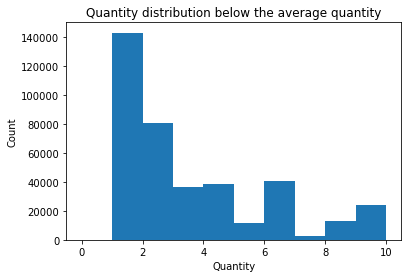

In [27]:
# analyzing quantities below the mean 
plt.hist(data=df ,x ='Quantity', range=(0,10))
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.title('Quantity distribution below the average quantity');

Very interesting to see that most customers only ordered one or two items of a prdocut they bought. This is true for approximately 40% of all orders!

In [28]:
print('By the way, our online store sold a total of {} items.'.format(df['Quantity'].sum()))

By the way, our online store sold a total of 5561567 items.


##### 2.1.1.1 Quantity Analysis per product (StockCode)

In [29]:
print('- On average, each unique product was bought {} times.'.format(round(df.groupby('StockCode')['Quantity'].sum().mean()),2))
print('- 50% of products were bought less than {} times and 50% more.'.format(df.groupby('StockCode')['Quantity'].sum().median()))
print('- The least favorite product was only bought {} time(s).'.format(df.groupby('StockCode')['Quantity'].sum().min()))
print('- The best seller was sold {} times.'.format(df.groupby('StockCode')['Quantity'].sum().max()))
print('- On average, each product appeared in {} unique orders.'.format(round(df.groupby('StockCode')['Quantity'].count().mean()),2))
print('- The most favorable product appeared in {} unique orders.'.format(df.groupby('StockCode')['Quantity'].count().max()))

- On average, each unique product was bought 1420 times.
- 50% of products were bought less than 369.0 times and 50% more.
- The least favorite product was only bought 1 time(s).
- The best seller was sold 80995 times.
- On average, each product appeared in 133 unique orders.
- The most favorable product appeared in 2253 unique orders.


##### 2.1.1.2 Quantity Analysis per order

In [30]:
print('- On average, each order consisted of {} items.'.format(round(df.groupby('InvoiceNo')['Quantity'].sum().mean()),2))
print('- 50% of orders included less than {} items and 50% more.'.format(df.groupby('InvoiceNo')['Quantity'].sum().median()))
print('- The order with the lowest quantity only included {} item(s).'.format(df.groupby('InvoiceNo')['Quantity'].sum().min()))
print('- The order with the highest quantity included {} items.'.format(df.groupby('InvoiceNo')['Quantity'].sum().max()))
print('- On average, each order consisted of {} unique products.'.format(round(df.groupby('InvoiceNo')['Quantity'].count().mean()),2))
print('- The largest order in terms of number of products had {} products.'.format(df.groupby('InvoiceNo')['Quantity'].count().max()))

- On average, each order consisted of 281 items.
- 50% of orders included less than 152.0 items and 50% more.
- The order with the lowest quantity only included 1 item(s).
- The order with the highest quantity included 80995 items.
- On average, each order consisted of 26 unique products.
- The largest order in terms of number of products had 1113 products.


Again, it is interesting to see that our online shop has such massive differences between the products and orders (and therefore also customers). In order to evaluate the profitability of each product, order and customer, we will cluster them in a later part to better understand each category's value to the company.

##### 2.1.2 Unit Price Analysis

In [31]:
# analyzing Unit price over all products and orders
display(df['UnitPrice'].describe())
print('- The difference between mean ({}) and median ({}) and thus the standard deviation is much lower compared to the Quantity. But we still see outliers like the maximum of {}.'.format(round(df['UnitPrice'].describe()[1],2),df['UnitPrice'].describe()[5], df['UnitPrice'].describe()[7])) 

count    522717.000000
mean          3.335198
std          24.588877
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

- The difference between mean (3.34) and median (2.08) and thus the standard deviation is much lower compared to the Quantity. But we still see outliers like the maximum of 13541.33.


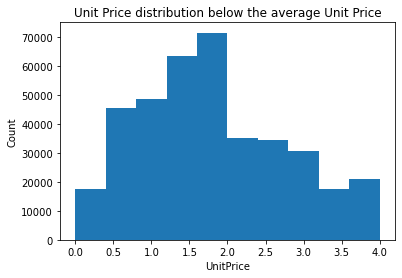

In [32]:
# visualize Unit Price distribution (below average)
plt.hist(data=df ,x ='UnitPrice', range=(0,4))
plt.xlabel('UnitPrice')
plt.ylabel('Count')
plt.title('Unit Price distribution below the average Unit Price');

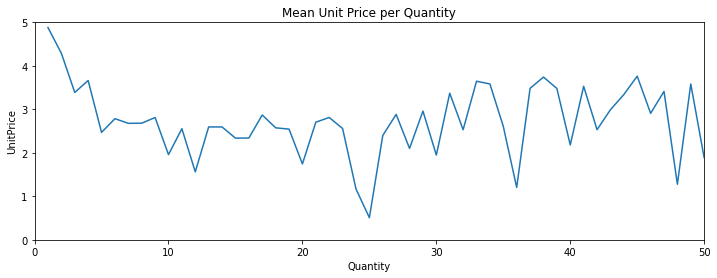

Quantity
1    4.880645
2    4.289509
3    3.388238
4    3.663185
Name: UnitPrice, dtype: float64

In [33]:
#Find out whether low quantities also go hand in hand with low unit prices
plt.figure(figsize=(12,4))
qu_up = df.groupby('Quantity')['UnitPrice'].mean()
plt.plot(qu_up)
plt.xlim(0,50)
plt.ylim(0,5)
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.title('Mean Unit Price per Quantity')
plt.show();
display(qu_up.head(4))

For low quantities, the mean unit price is higher than the overall mean. This is good news as orders only consisting of low quantities and low unit prices are definetly not worth the effort. In order to see if  a minimum order value should be introduced, we will use our Revenue column.

###### 2.1.3. Revenue Analysis

In [34]:
print('The overall generated revenue is {}$.'.format(round(df['Revenue'].sum()),0))

The overall generated revenue is 10279842$.


##### 2.1.3.1 Revenue per product (StockCode)

In [35]:
print('- On average, a revenue of {}$ was generated per product'.format(round(df.groupby('StockCode')['Revenue'].sum().mean()),0))
print('- 50% of the products made a revenue of more than {}$ and 50% less.'.format(df.groupby('StockCode')['Revenue'].sum().median()))
print('- The highest generating product made a total revenue of {}$.'.format(df.groupby('StockCode')['Revenue'].sum().max()))
print('- The lowest generating product only made a revenue of {}$.'.format(df.groupby('StockCode')['Revenue'].sum().min()))

- On average, a revenue of 2624$ was generated per product
- 50% of the products made a revenue of more than 680.55$ and 50% less.
- The highest generating product made a total revenue of 174156.54$.
- The lowest generating product only made a revenue of 0.003$.


##### 2.1.3.2 Revenue per order

In [36]:
print('- On average, a revenue of {}$ was generated per order'.format(round(df.groupby('InvoiceNo')['Revenue'].sum().mean(),0)))
print('- 50% of the orders made a revenue of more than {}$ and 50% less.'.format(df.groupby('InvoiceNo')['Revenue'].sum().median()))
print('- The lowest revenue any order has ever made is {}$.'.format(df.groupby('InvoiceNo')['Revenue'].sum().min()))
print('- The highest revenue any order has ever made is {}$.'.format(df.groupby('InvoiceNo')['Revenue'].sum().max()))

- On average, a revenue of 520.0$ was generated per order
- 50% of the orders made a revenue of more than 302.33$ and 50% less.
- The lowest revenue any order has ever made is 0.38$.
- The highest revenue any order has ever made is 168469.6$.


Order revenues of only 0.38 USD or products which only generated 0.003 USD are not worth the effort. This is why we should think about the introduction of a minimum order value. For this we can e.g.take a look at the bottom 5 percent of orders.

In [37]:
round(df.groupby('InvoiceNo')['Revenue'].sum().quantile(0.05),1)

24.9

A minimum order value of 25$ would be reasonable here. More on this, in the hypotheses part.

###### 2.1.3.3 Revenue over time

In [38]:
# identifying time period between first and last order 
print('- The earliest order was placed on {}.'.format(df['InvoiceDate'].min()))
print('- The latest order was placed on {}.'.format(df['InvoiceDate'].max()))
print('- This equals a total time period of {}.'.format(df['InvoiceDate'].max() - df['InvoiceDate'].min()))

- The earliest order was placed on 2018-11-29 08:26:00.
- The latest order was placed on 2019-12-07 12:50:00.
- This equals a total time period of 373 days 04:24:00.


##### 2.1.3.3.1 Revenue per date

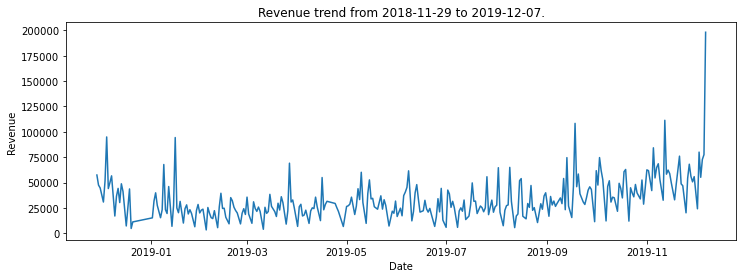

In [39]:
# inspecting total revenue per date
revenue_trend= df.groupby('Date')['Revenue'].sum()
plt.figure(figsize=(12,4))
sb.lineplot(data=revenue_trend)
plt.title('Revenue trend from 2018-11-29 to 2019-12-07.')
plt.show();

In [40]:
print('- On average, {}$ of revenue were made per day.'.format(round(df.groupby('Date')['Revenue'].sum().mean()),0))
print('- 50% of days generated more than {}$ of revenue and 50% less.'.format(df.groupby('Date')['Revenue'].sum().median()))
print('- The maximum revenue generated on one day was {}$.'.format(round(df.groupby('Date')['Revenue'].sum().max()),0))
print('- The minimum revenue generated on one day was {}$.'.format(round(df.groupby('Date')['Revenue'].sum().min()),0))

- On average, 33704$ of revenue were made per day.
- 50% of days generated more than 28559.32$ of revenue and 50% less.
- The maximum revenue generated on one day was 198095$.
- The minimum revenue generated on one day was 3440$.


##### 2.1.3.3.2 Revenue per month

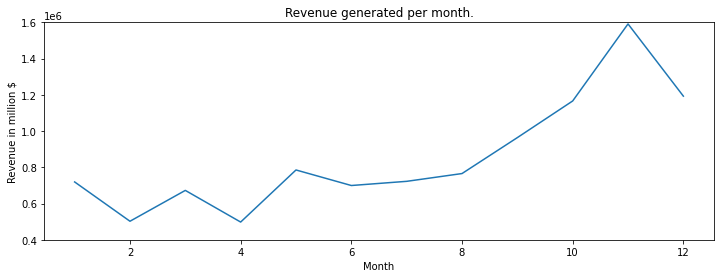

In [41]:
# inspecting total revenue per month
revenue_month= df.groupby('Month')['Revenue'].sum()
plt.figure(figsize=(12,4))
sb.lineplot(data=revenue_month)
plt.title('Revenue generated per month.')
plt.ylim(400000,1600000)
plt.ylabel('Revenue in million $')
plt.show();

We can see some seasonality here as it generally increases towards the end of the year and christmas season. To be fair, we have to account for the fact that, the data includes 373 days, so 8 days in November and December are counted twice. But even withourt these days, we can clearly see the peak. 
When clustering our products, we should definetly look out for christmas products.

##### 2.1.3.3.3 Revenue per weekday

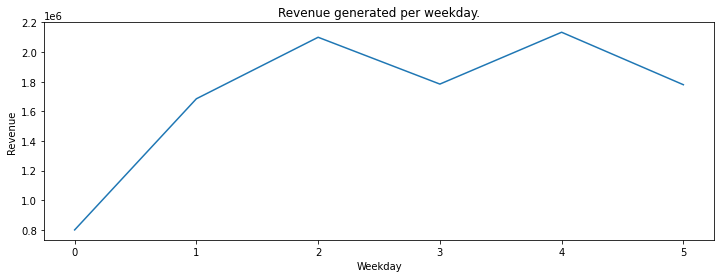

In [42]:
# inspecting total revenue per weekday
revenue_weekday= df.groupby('Weekday')['Revenue'].sum()
plt.figure(figsize=(12,4))
sb.lineplot(data=revenue_weekday)
plt.title('Revenue generated per weekday.')
plt.show();

Except Mondays, all other weekdays share a similar revenue distribution. For some reason, Sundays are not included in the statistics, which seems irrational as an online shop never really closes I believe. 
The reason might be that the data is not tracked on Sundays which is not optimal and I would advise the Online Shop to also include Sundays in order to get better customer and product insights.

##### 2.1.3.3.4 Revenue per hour

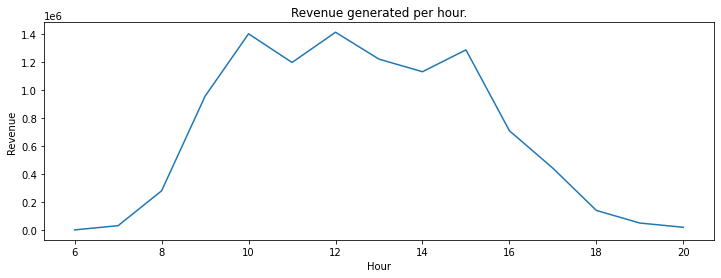

In [43]:
revenue_hour= df.groupby('Hour')['Revenue'].sum()
plt.figure(figsize=(12,4))
sb.lineplot(data=revenue_hour)
plt.title('Revenue generated per hour.')
plt.show();

Similar to weekdays, we can only find business hour data. There is no data displayed for any time after 8pm, which is of course possible due to chance but seems very unlikely for an online shop in the course of more than a year. Again, this data would have been insightful, by e.g. identifying products which are typically purchased late at night when other, physical stores are closed already.
In general, most revenue is generated between 9am and 4 pm, which represent the typical business hour time span. 

##### 2.1.4 Product Clustering

One of our overall goals is to reduce the total prodcut offer in order to operate more efficiently and to be more profitable at the same time. As it would have been to time-intensive to look at each product individually, we will try to cluster our products in different groups based on their product description.

Unfortunately, the algorithm takes up a lot of memory and needs a very long time to run certain components would take too long (e.g. additional Stemming). This is why the cells are all markdowns. Cells can be run by changing back to code.

In [44]:
#change description to lower case
df['Description'] = df['Description'].str.lower()

In [45]:
#define a function to preprocess
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [46]:
#apply function to Description data
df['cleaned'] = df['Description'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [47]:
#initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
#fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned'])

In [49]:
from sklearn.cluster import KMeans

#initialize kmeans with 10 centroids
kmeans = KMeans(n_clusters=10, random_state=42)
#fit the model
kmeans.fit(X)
#store cluster labels in a variable
clusters = kmeans.labels_

In [50]:
#add clusters to df
df['cluster']= clusters

In [51]:
#identify top keywords to describe each cluster
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(3)


Cluster 0
pink,box,heart

Cluster 1
bag,red,retrospot

Cluster 2
lunch,jumbo,bag

Cluster 3
scandinavian,frame,wooden

Cluster 4
spotty,party,bunting

Cluster 5
french,sign,metal

Cluster 6
regency,tins,set

Cluster 7
bakelike,alarm,clock

Cluster 8
hanging,holder,light

Cluster 9
cake,cases,pack


In [52]:
#map clusters to appropriate labels 
cluster_map = {0: "pink", 1: "bags", 2: "lunch", 3:"wood", 4:"party",5:"metal", 6:"tins", 7:"alarms",8:"holders", 9:"cakes"}
#apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

In [54]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Revenue,InvoiceDate,Date,Month,Weekday,Hour,CustomerID,cleaned,cluster
0,536365,85123A,white hanging heart t-light holder,6,2.55,15.30,2018-11-29 08:26:00,2018-11-29,11,3,8,17850,white hanging heart light holder,holders
1,536365,71053,white metal lantern,6,3.39,20.34,2018-11-29 08:26:00,2018-11-29,11,3,8,17850,white metal lantern,metal
2,536365,84406B,cream cupid hearts coat hanger,8,2.75,22.00,2018-11-29 08:26:00,2018-11-29,11,3,8,17850,cream cupid hearts coat hanger,pink
3,536365,84029G,knitted union flag hot water bottle,6,3.39,20.34,2018-11-29 08:26:00,2018-11-29,11,3,8,17850,knitted union flag hot water bottle,pink
4,536365,84029E,red woolly hottie white heart.,6,3.39,20.34,2018-11-29 08:26:00,2018-11-29,11,3,8,17850,red woolly hottie white heart,pink


In [65]:
# calculate revenue_per_cluster
revenue_per_cluster = df.groupby('cluster')['Revenue'].mean()
revenue_per_cluster.sort_values(ascending=False)

cluster
party      37.289673
holders    30.399315
alarms     24.543995
bags       22.158206
lunch      21.668687
tins       20.994244
pink       18.364652
wood       17.995609
metal      16.136277
cakes      15.510918
Name: Revenue, dtype: float64

### 2.2 Customer Analysis

#### 2.2.1 Customer Overview

In [66]:
# copy existing data frame for customer analysis
customers = df.copy()
# delete null values as it does not make sense to cluster null values
customers.dropna();

In [67]:
print('- In total, there are {} unique customers.'.format(customers['CustomerID'].nunique()))
print('- The most active user ordered {} times.'.format(customers.groupby('InvoiceNo')['CustomerID'].count().max()))
print('- On average, each user ordered {} times.'.format(round(customers.groupby('InvoiceNo')['CustomerID'].count().mean()),0))
print('- On average, each user generated {}$ of revenue.'.format(round(customers.groupby('CustomerID')['Revenue'].sum().mean()),0))


- In total, there are 4334 unique customers.
- The most active user ordered 541 times.
- On average, each user ordered 20 times.
- On average, each user generated 2018$ of revenue.


#### 2.2 Customer Clustering based on RFM

In [68]:
# copy existing data frame for customer analysis
customers = df.copy()
# delete null values
customers.dropna();

RFM overview:

- Recency = Number of days since the last purchase
- Frequency = Number of transactions made over a given period
- Monetary = Amount spent over a given period of time

In [69]:
# create a snapshot date to compare recency ( we will use 1 day after the last purchase here)
snapshot_date = customers['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2019-12-08 12:50:00


In [70]:
# Grouping by CustomerID
rfm = customers.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'Revenue': 'sum'})

# rename the columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Revenue': 'Monetary'}, inplace=True)

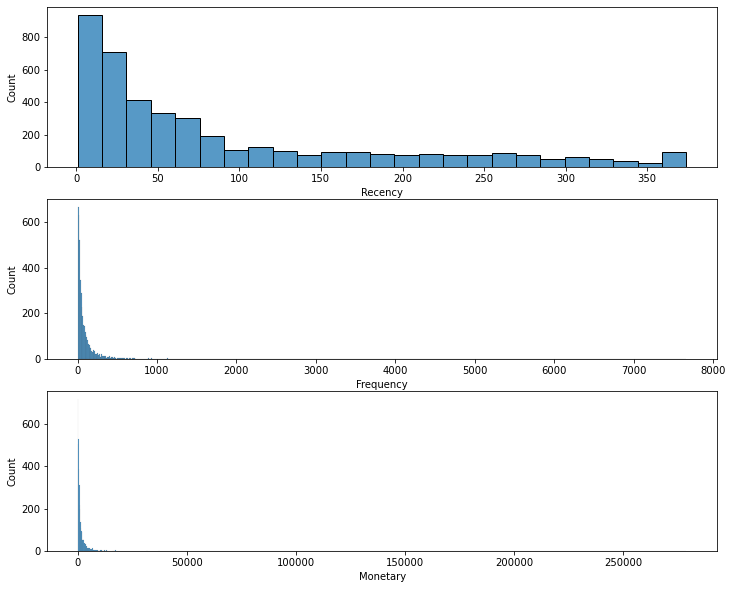

In [71]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sb.histplot(rfm['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sb.histplot(rfm['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sb.histplot(rfm['Monetary'])
# Show the plot
plt.show();

We can clearly see that our data is highly skewed!

In [72]:
# calculate recency groups

# assign labels (remember that the lower the number the better)
recency_labels = range(4,0,-1)
# use qcut to split into percentiles
recency_groups = pd.qcut(rfm['Recency'], q=4, labels=recency_labels)
# create a column R
rfm = rfm.assign(R = recency_groups.values)

In [73]:
# calculate frequency groups

# assign labels
frequency_labels = range(1,5)
# use qcut to split into percentiles
frequency_groups = pd.qcut(rfm['Frequency'], q=4, labels=frequency_labels)
# create a column F
rfm = rfm.assign(F = frequency_groups.values)

In [74]:
# calculate monetary groups

# assign labels
monetary_labels = range(1,5)
# use qcut to split into percentiles
monetary_groups = pd.qcut(rfm['Monetary'], q=4, labels=monetary_labels)
# create a column F
rfm = rfm.assign(M = monetary_groups.values)

In [75]:
# assing overall RFM score
rfm['RFM_score'] = rfm[['R','F','M']].sum(axis=1)
# change data type to categorical
rfm['RFM_score'] = rfm['RFM_score'].astype('category')

In [76]:
# assign action labels to rfm scores
def action_level(df):
    if df['RFM_score'] >= 10:
        return 'Key'
    elif ((df['RFM_score'] >= 8) and (df['RFM_score'] < 10)):
        return 'Loyal'
    elif ((df['RFM_score'] >= 6) and (df['RFM_score'] < 8)):
        return 'Last chance'
    else:
        return 'Unimportant'

In [77]:
# apply to our dataframe
rfm['RFM_level'] = rfm.apply(action_level, axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_score,RFM_level
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,4,6,Last chance
12347,2,182,4310.00,4,4,4,12,Key
12348,75,27,1437.24,2,2,3,7,Last chance
12349,19,72,1457.55,3,3,3,9,Loyal
12350,310,16,294.40,1,1,1,3,Unimportant


In [78]:
# groupby RFM-level
rfm_overview = rfm.groupby(['RFM_level']).agg({'Recency':'mean', 'Frequency':'mean', 'Monetary':['mean','count']})
display(rfm_overview)

Recency   Frequency     Monetary      
                   mean        mean         mean count
RFM_level                                             
Key           20.054936  225.876592  5178.887882  1256
Last chance   88.383025   33.078346   781.682601   919
Loyal         55.089552   66.405281  1356.299497   871
Unimportant  192.064441   15.020963   263.608145  1288

Very interesting customer insights! We can see that the largest group of customers belongs to the 'worst' customer group, which is generally a bad sign. Luckily we also have many key customers and also a fair amount of 'loyal' and 'last chance' customers.

In order to increase efficiency and meet our pre-defined goals, we should differentiate between the different groups with respect to which action to take:

1. Key Customers: Our main focus as they contribute large parts of overall revenue and profit. We should provide them with some premium offers and information in order to ensure a long-lasting relationship.
2. Loyal customers: We should invest some resources to try to push them to become a key customer. Giving them discounts, including them in newsletters to get all information they need to finally increase their RFM metrics.
3. Last chance customers: It might be the very last chance in order to keep these customers. 88 days on average after their last purchase, it is difficult to finally persuade them to be more active as they haven't been so far. We should invest a limited amount of resources in order to find out more about the reasons they have such bad metrics.
4. Unimportant customers : In order to meet the overall goal of focusing only on the most promising products and customers, we have to be honest and admit that this customer group does not add value at all and is irrelevant for further planning. Additional resources would just be a waste of money.

#### 2.3 Macro Data Analysis

Most of our data was collected at the end of 2018 and in the year of 2019. The next stept would be to compare it to previous years and then later put the numbers into the context of the overall macro situation in the UK.  

In [79]:
# loading a comparable dataset from 2010 and 2011 found on Kaggle
compare_df = pd.read_csv('compare_dataset.csv', encoding= 'unicode_escape')
compare_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


##### 2.3.1 Short data cleaning and preprocessing on new dataset

In [80]:
# loading a comparable dataset from 2010 and 2011 found on Kaggle
compare_df = pd.read_csv('compare_dataset.csv', encoding= 'unicode_escape')

In [81]:
# change data types
compare_df['InvoiceDate'] =pd.to_datetime(compare_df['InvoiceDate'])
compare_df['CustomerID'] = compare_df['CustomerID'].astype('object')
# drop duplicates
compare_df.drop_duplicates(keep='first', inplace=True)
# only include customers from the United Kingdom in order to ensure comparability
compare_df = compare_df[compare_df['Country'] == 'United Kingdom']
# perform cleaning steps as in df
compare_df = compare_df.query('Description != "POSTAGE" and Description != "DOTCOM POSTAGE"')
compare_df = compare_df[compare_df['Description'] != 'Bank Charges']
compare_df = compare_df[compare_df['Description'] != 'Manual']
compare_df = compare_df[compare_df['UnitPrice'] > 0]
compare_df= compare_df[compare_df['Quantity'] >= 0 ]
# add columns as in df
compare_df['Revenue'] = compare_df['Quantity'] * compare_df['UnitPrice']
compare_df['Date'] = compare_df['InvoiceDate'].dt.date
compare_df['Month'] = compare_df['InvoiceDate'].dt.month
compare_df['Weekday'] = compare_df['InvoiceDate'].dt.weekday
compare_df['Hour'] = compare_df['InvoiceDate'].dt.hour

In [82]:
# check if compare_df includes similar number of days
time_period_2018_2019 = df['InvoiceDate'].max() - df['InvoiceDate'].min()
time_period_2010_2011 = compare_df['InvoiceDate'].max() - compare_df['InvoiceDate'].min()
print(time_period_2018_2019, time_period_2010_2011)

373 days 04:24:00 373 days 04:23:00


##### 2.3.2 Apply RFM segmentation to new dataset

In [83]:
# drop missing values
compare_df.dropna();

In [84]:
# create a snapshot date to compare recency ( we will use 1 day after the last purchase here)
snapshot_date_compare = compare_df['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date_compare)

2011-12-10 12:49:00


In [85]:
# Grouping by CustomerID
compare_rfm = compare_df.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date_compare - x.max()).days,
        'InvoiceNo': 'count',
        'Revenue': 'sum'})

# rename the columns
compare_rfm.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Revenue': 'Monetary'}, inplace=True)

In [86]:
# calculate recency groups

# assign labels (remember that the lower the number the better)
recency_labels = range(4,0,-1)
# use qcut to split into percentiles
recency_groups = pd.qcut(compare_rfm['Recency'], q=4, labels=recency_labels)
# create a column R
compare_rfm = compare_rfm.assign(R = recency_groups.values)

In [87]:
# calculate frequency groups

# assign labels
frequency_labels = range(1,5)
# use qcut to split into percentiles
frequency_groups = pd.qcut(compare_rfm['Frequency'], q=4, labels=frequency_labels)
# create a column F
compare_rfm = compare_rfm.assign(F = frequency_groups.values)

In [88]:
# calculate monetary groups

# assign labels
monetary_labels = range(1,5)
# use qcut to split into percentiles
monetary_groups = pd.qcut(compare_rfm['Monetary'], q=4, labels=monetary_labels)
# create a column F
compare_rfm = compare_rfm.assign(M = monetary_groups.values)

In [89]:
# assing overall RFM score
compare_rfm['RFM_score'] = compare_rfm[['R','F','M']].sum(axis=1)
# change data type to categorical
compare_rfm['RFM_score'] = compare_rfm['RFM_score'].astype('category')

In [90]:
# assign action labels to rfm scores
def action_level(df):
    if df['RFM_score'] >= 10:
        return 'Key'
    elif ((df['RFM_score'] >= 8) and (df['RFM_score'] < 10)):
        return 'Loyal'
    elif ((df['RFM_score'] >= 6) and (df['RFM_score'] < 8)):
        return 'Last chance'
    else:
        return 'Unimportant'

In [91]:
# apply to our dataframe
compare_rfm['RFM_level'] = compare_rfm.apply(action_level, axis=1)
compare_rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_score,RFM_level
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,Last chance
12747.0,2,103,4196.01,4,4,4,12,Key
12748.0,1,4397,31650.78,4,4,4,12,Key
12749.0,4,199,4090.88,4,4,4,12,Key
12820.0,3,59,942.34,4,3,3,10,Key


In [92]:
# RFM statistics 2010-2011
compare_rfm_overview = compare_rfm.groupby(['RFM_level']).agg({'Recency':'mean', 'Frequency':'mean', 'Monetary':['mean','count']})
display(compare_rfm_overview)

Recency   Frequency     Monetary      
                   mean        mean         mean count
RFM_level                                             
Key           19.865267  221.300962  4605.853088  1143
Last chance   89.421376   33.045455   777.205725   814
Loyal         54.255696   65.513924  1323.467813   790
Unimportant  191.014542   14.801540   258.045518  1169

In [93]:
# RFM statistics 2018-2019
rfm_overview = rfm.groupby(['RFM_level']).agg({'Recency':'mean', 'Frequency':'mean', 'Monetary':['mean','count']})
display(rfm_overview)

Recency   Frequency     Monetary      
                   mean        mean         mean count
RFM_level                                             
Key           20.054936  225.876592  5178.887882  1256
Last chance   88.383025   33.078346   781.682601   919
Loyal         55.089552   66.405281  1356.299497   871
Unimportant  192.064441   15.020963   263.608145  1288

Of course, one can see that these datasets were almost identical and do not come from real-life data collected in the respected years. This is one reason why we almost see no difference in any of the RFM metrics. Nevertheless, I will now use some macro UK data to further analyze similarities and differences between the two datasets and will evaluate if the online company is on the right track.

##### 2.3.3. Macro Data Analysis

In [94]:
# importing created excel file with data on GDP, inflation rate and % of retail sales made online 
macro = pd.read_excel('macro.xlsx')
macro

,Year,GDP (billion USD),Inflation rate (in %),% of retail sales made online
0,2010,2.48,2.49,7.4
1,2011,2.66,3.86,8.5
2,2012,2.70,2.57,9.5
3,2013,2.78,2.29,10.3
4,2014,3.07,1.45,11.2
5,2015,2.93,0.37,12.8
6,2016,2.69,1.01,14.9
7,2017,2.66,2.56,16.5
8,2018,2.86,2.29,17.8
9,2019,2.83,1.74,19.1


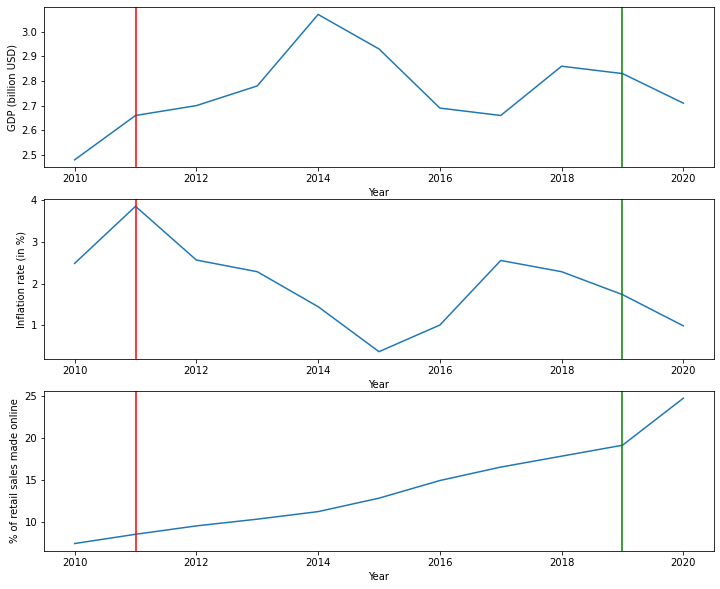

In [95]:
# plotting the different macro-data to get an overview
plt.figure(figsize=(12,10))
# GDP
plt.subplot(3, 1, 1); sb.lineplot(data=macro, x='Year', y='GDP (billion USD)'); 
plt.axvline(x=2011, color='red'); plt.axvline(x=2019, color='green')
# inflation rate (2011 and 2019 are idenitified as main years)
plt.subplot(3, 1, 2); sb.lineplot(data=macro, x='Year', y='Inflation rate (in %)')
plt.axvline(x=2011, color='red'); plt.axvline(x=2019, color='green')
# online retail sales (2011 and 2019 are idenitified as main years)
plt.subplot(3, 1, 3); sb.lineplot(data=macro, x='Year', y='% of retail sales made online')
plt.axvline(x=2011, color='red'); plt.axvline(x=2019, color='green')
# Show the plot (2011 and 2019 are idenitified as main years)
plt.show();

Under the assumption that the datasets included real-life data which was in no form identical to each other, we can draw the following conclusions:

1. GDP: From 2011 to 2019, the GDP has slightly increased from 2.66 billion USD to 2.83 billion USD. This is a percentage increase of 6.3% and is very similar to the increase in revenue per order (6.4%) from 2011 to 2019. According to the GDP, the online shop has performed as expected.

2. Inflation rate: The inflation rate in 2011 of 3.86% was comparably high and much higher compared to the 1.74% in 2019. Genreally, the inflation rate was positive, meaning that products should have increased in price over time. Taking into consideration the inflation rates from 2010 until 2019 and multiply them, products are expected to cost about 14% more. But when we look at our date frames we can see, that the average unit price remained unchanged. Considering the increased costs for our online shop (storage costs, labour costs etc.), the online shop probably made less profit and really has to think about a unit price increase.

3. Retail sales made online: Unsurprisingly, online sales exploded over the last years. While less than 10% of total retail sales were made online in 2011, nearly one in five will be in 2019. Unfortunately, our online ship could not profit from this trend. Even though the total number of one-off orders has increased from 17906 to 19781, these figures are far from doubling.

In [96]:
# GDP calculations
print('Revenue per order from 2018 to 2019 is {}$.'.format(round(df['Revenue'].sum() / df['InvoiceNo'].nunique()),0))
print('Revenue per order from 2010 to 2011 is {}$.'.format(round(compare_df['Revenue'].sum() / compare_df['InvoiceNo'].nunique()),0))

Revenue per order from 2018 to 2019 is 520$.
Revenue per order from 2010 to 2011 is 489$.


In [97]:
# inflation rate calcualtions
print('The average unit price from 2018 to 2019 was {}$.'.format(df['UnitPrice'].mean()))
print('The average unit price from 2010 to 2011 was {}$.'.format(compare_df['UnitPrice'].mean()))

The average unit price from 2018 to 2019 was 3.335198133971769$.
The average unit price from 2010 to 2011 was 3.3585087129830224$.


In [98]:
# online retail sales calculations
print('The total number of unique orders between 2018 and 2019 was {}.'.format(df['InvoiceNo'].nunique()))
print('The total number of unique orders between 2010 and 2011 was {}.'.format(compare_df['InvoiceNo'].nunique()))

The total number of unique orders between 2018 and 2019 was 19781.
The total number of unique orders between 2010 and 2011 was 17906.


### 3. Testing hypotheses

#### 3.1 First Hypothesis:

"20% of the total customers are responsible for 80% of the total revenue".

In [99]:
# copy original data frame for this special task
df_revenue = df.copy()
# drop missing CustomerIDs 
df_revenue.dropna(subset=['CustomerID']);

In [100]:
# group by customer and diplay total revenue per customers
rev_per_cust= df_revenue.groupby('CustomerID')['Revenue'].sum()
# sort the results in descending order
rev_per_cust= rev_per_cust.sort_values(ascending=False)
#get top 20% by dividing the number of unique Customers by 5
top_20_percent = int(round(df_revenue['CustomerID'].nunique()/5,0))
# get the total revenue of the top 20% of customers
revenue_of_top_20_perc = rev_per_cust[0:top_20_percent].sum()

In [101]:
# calcualting total revenue made by all customers
overall_revenue = df_revenue['Revenue'].sum()
#calculate ratio of overall revenue (expected > 80%)
first_hypothesis = round(revenue_of_top_20_perc/overall_revenue*100,0)
print(first_hypothesis)

63.0


My initial hypothesis was not true. The top 20% of customers in terms of revenue are only responsible for 63% of the overall profit but not for 80%.

#### 3.2 Second Hypothesis:

"Cheap products (products which cost 2$ or less) are responsible for more than 70% of total revenue".

In [102]:
# create new dataframe for our second hypothesis
df_cheap =df.copy()

In [103]:
# filter for products which cost 2$ or less
df_cheap = df_cheap[df_cheap['UnitPrice'] <=2]

In [104]:
# calculate total revenue of cheap products
df_cheap_revenue = df_cheap['Revenue'].sum()

In [105]:
# calcualting percentage of total revenue (expected to be > 70)
second_hypothesis = round(df_cheap_revenue / overall_revenue *100,0)
print(second_hypothesis)

37.0


This time I was not wrong, I was very wrong! Cheap products only contribute 37% to the total revenue. By the way, my hypothesis would have been true if I would have included products which cost 5$ or less.

#### 3.3 Third Hypothesis:

"Products with shorter product description (shorter than the median) are bought more frequently."

In [106]:
# create new dataframe for third hypothesis
df_description = df.copy()
# drop missing description values as they do not have a length
df_description.dropna(subset=['Description'])
#create a column to display charachter lenght of each description
df_description['description_length'] = [len(x) for x in df_description['Description']]

In [107]:
# calculating median lenght to divide products into two groups
median = int(df_description['description_length'].median())
# creating a group with products which have a description length shorter than the median
group_short = df_description[df_description['description_length'] < median]
# creating a group with products which have a description length longer than the median
group_long = df_description[df_description['description_length'] > median]

In [108]:
# calculating total quantity of products with a product length less than the median
quantity_group_short = group_short['Quantity'].sum()
# calculating total quantity of products with a product length longer than the median
quantity_group_long = group_long['Quantity'].sum()

In [109]:
#compare the qunatity of the two groups with a boolean expression (expected to be true)
third_hypothesis = quantity_group_short > quantity_group_long
print(third_hypothesis)

False


In [110]:
# print actual values
print('quantity_group_short: {}'.format(quantity_group_short))
print('quantity_group_long: {}'.format(quantity_group_long))

quantity_group_short: 2493953
quantity_group_long: 2658142


That's three wrong hypotheses in a row! Although it was close this time, products with a longer product description were bought more often than ones with a shorter description.

#### 3.4 Fourth Hypothesis:

"Most revenue is made around christmas time ( in the second half of December)."

In [111]:
# creating a new frame for this hypothesis
df_christmas = df.copy()

In [112]:
# exclude dates which were included in 2018 and 2019
df_christmas = df_christmas[df_christmas['InvoiceDate'] >'2018-12-07']

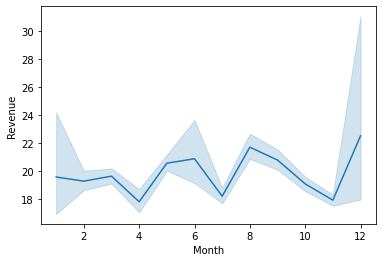

In [113]:
# plot revenue
sb.lineplot(data=df_christmas, x='Month', y='Revenue');

Without further calculations, it is easy to see that this hypothesis is indeed correct. Unsurprisingly for an online shop, the December outperformed all other months.

### 4. Conclusions and call to action

After long days of analysis and several insights which were derived from the data, it is time to finally meet the overall goal by drastically reducing product offer and identyfying customers on which not to spend any resources on.

In [176]:
#copy df to create a final_df
final_df = df.copy()

In [177]:
# calculate revenue_per_cluster
revenue_per_cluster = df.groupby('cluster')['Revenue'].mean()
revenue_per_cluster.sort_values(ascending=False)

cluster
party      37.289673
holders    30.399315
alarms     24.543995
bags       22.158206
lunch      21.668687
tins       20.994244
pink       18.364652
wood       17.995609
metal      16.136277
cakes      15.510918
Name: Revenue, dtype: float64

In [178]:
# remove the 40% lowest clusters with regard to average revenue (cakes, metal, wood,tins)
final_df = final_df[final_df['cluster'] != 'cakes']
final_df = final_df[final_df['cluster'] != 'metal']
final_df = final_df[final_df['cluster'] != 'wood']
final_df = final_df[final_df['cluster'] != 'tins']

In [181]:
print('Number of unique prodcuts before removing low-revneue products: {}.'.format(df['StockCode'].nunique()))
print('Number of unique prodcuts after removing low-revneue products: {}.'.format(final_df['StockCode'].nunique()))

Number of unique prodcuts before removing low-revneue products: 3917.
Number of unique prodcuts after removing low-revneue products: 3353.


We finally reduced our total product offer by almost 400 prodcuts. This may help our shop to further increase profitability.

In [182]:
#copy rfm to create final_rfm
final_rfm = rfm.copy()

In [183]:
# remove unimportant / irrelevant customers
final_rfm = final_rfm[final_rfm['RFM_level'] != 'Unimportant']

In [188]:
print('Total number of unique customers before: {}.'.format(len(rfm)))
print('Total number of unique customers after: {}.'.format(len(final_rfm)))

Total number of unique customers before: 4334.
Total number of unique customers after: 3046.


We have identified more than 1200 customers which are not worth spending resources (like marketing etc.) on. By doing this, we can spend more resources on customers which really add value to our business.

### 5. Dashboards

Tableau Link: